In [2]:
import os
from shutil import copyfile
db_path = "/content/drive/MyDrive/Deep learning Class Project/plankton_db"
classes = os.listdir(db_path)
print(classes)

['Ceratium', 'Cerataulina', 'Chaetoceros', 'Entomoneis', 'Guinardia', 'Hemiaulus', 'Nitzschia', 'Lauderia annulata', 'Noctiluca', 'Alexandrium', 'Pyrodinium', 'Protoperidinium', 'Prorocentrum', 'Pleurosigma', 'Pinnularia', 'Thalassiosira', 'Asterionellopsis glacialis', 'Thalassionema', 'Ornithocercus magnificus']


In [3]:
#!pip install --upgrade pillow
#db_path = "/content/drive/MyDrive/Deep learning Class Project/dataset_pm/training"
train_path = '/content/drive/MyDrive/Deep learning Class Project/dataset_pm/training'
validation_path = '/content/drive/MyDrive/Deep learning Class Project/dataset_pm/validation'
test_path = '/content/drive/MyDrive/Deep learning Class Project/dataset_pm/test'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from numpy.random import seed
seed(1337)
import tensorflow as tf
tf.random.set_seed(42)

from tensorflow.python.keras.applications import vgg16
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, models, Model, optimizers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#from plot_conf_matr import plot_confusion_matrix

In [5]:
import os
category_names = sorted(os.listdir(train_path))
nb_categories = len(category_names)

In [6]:
img_height, img_width = 224, 224

conv_base = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
conv_base.trainable = False   # freeze the convolutional base
for i, layer in enumerate(conv_base.layers):
    print(i, layer.name, layer.trainable)

58892288/58889256 [==============================] - 0s 0us/step
0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


### A. Pretrained model as Eeature Extractor

Just a pretrained model with dense layers added on the top as classifier

In [7]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(nb_categories, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 19)                4883      
Total params: 21,142,355
Trainable params: 6,427,667
Non-trainable params: 14,714,688
_________________________________________________________________


In [8]:
# Data augmentation
batch_size = 16

train_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,                                 
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   brightness_range = (0.9,1.1),
                                   fill_mode='nearest')
 
val_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(rescale = 1./255)

print('Total number of images for training: ')
train_generator = train_datagen.flow_from_directory(train_path, 
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size, 
                                                    class_mode = "categorical")

print('Total number of images for validation: ')
val_generator = val_datagen.flow_from_directory(validation_path,
                                                target_size=(img_height, img_width),
                                                batch_size=batch_size, 
                                                class_mode = "categorical",
                                                shuffle = False)
                                                
print('Total number of images for testing: ')
test_generator = test_datagen.flow_from_directory(test_path,
                                                target_size=(img_height, img_width),
                                                batch_size=batch_size, 
                                                class_mode = "categorical",
                                                shuffle = False)    

print(test_generator.class_indices)

Total number of images for training: 
Found 2872 images belonging to 19 classes.
Total number of images for validation: 
Found 93 images belonging to 19 classes.
Total number of images for testing: 
Found 118 images belonging to 19 classes.
{'Alexandrium': 0, 'Asterionellopsis glacialis': 1, 'Cerataulina': 2, 'Ceratium': 3, 'Chaetoceros': 4, 'Entomoneis': 5, 'Guinardia': 6, 'Hemiaulus': 7, 'Lauderia annulata': 8, 'Nitzschia': 9, 'Noctiluca': 10, 'Ornithocercus magnificus': 11, 'Pinnularia': 12, 'Pleurosigma': 13, 'Prorocentrum': 14, 'Protoperidinium': 15, 'Pyrodinium': 16, 'Thalassionema': 17, 'Thalassiosira': 18}


In [9]:
learning_rate = 5e-5
epochs = 100 
stepPerEpoch_training =  150 // batch_size 
checkpoint = ModelCheckpoint("plankton_classifier2.h5", 
                             monitor = 'val_acc',
                             verbose=1, 
                             save_best_only = True, 
                             save_Weights_only = False, 
                             mode = 'auto', period=1)

model.compile(loss = "categorical_crossentropy", 
              optimizer = optimizers.Adam(lr = learning_rate, clipnorm = 1.),
              metrics = ['acc'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=stepPerEpoch_training, 
                              epochs=epochs,
                              shuffle=True,
                              validation_data=val_generator,
                              callbacks=[checkpoint])
model.save_weights('wights.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
9/9 [==============================] - 121s 10s/step - loss: 3.1471 - acc: 0.0431 - val_loss: 2.7977 - val_acc: 0.1183

Epoch 00001: val_acc improved from -inf to 0.11828, saving model to plankton_classifier2.h5
Epoch 2/100
9/9 [==============================] - 65s 7s/step - loss: 2.9134 - acc: 0.1026 - val_loss: 2.6579 - val_acc: 0.2366

Epoch 00002: val_acc improved from 0.11828 to 0.23656, saving model to plankton_classifier2.h5
Epoch 3/100
9/9 [==============================] - 65s 7s/step - loss: 2.7539 - acc: 0.1538 - val_loss: 2.6171 - val_acc: 0.2366

Epoch 00003: val_acc did not improve from 0.23656
Epoch 4/100
9/9 [==============================] - 63s 7s/step - loss: 2.5726 - acc: 0.2379 - val_loss: 2.4668 - val_acc: 0.3333

Epoch 00004: val_acc improved from 0.23656 to 0.33333, saving model to plankton_classifier2.h5
Epoch 5/100
9/9 [==============================] - 53s 6s/step - loss: 2.4375 - acc: 0.2747 - val_loss: 2.1708 - val_acc: 0.3441

Epoch 00005: val

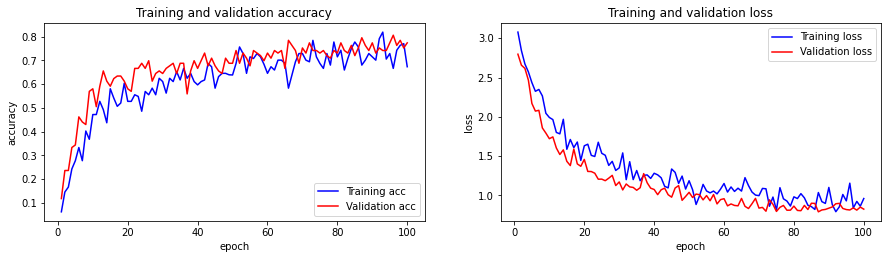

In [10]:
model = models.load_model("plankton_classifier2.h5")

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(epochs, acc, 'b', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
#plt.savefig('Accuracy.jpg')


plt.subplot(222)
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()

plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Accuracy in test set: 76.3% 


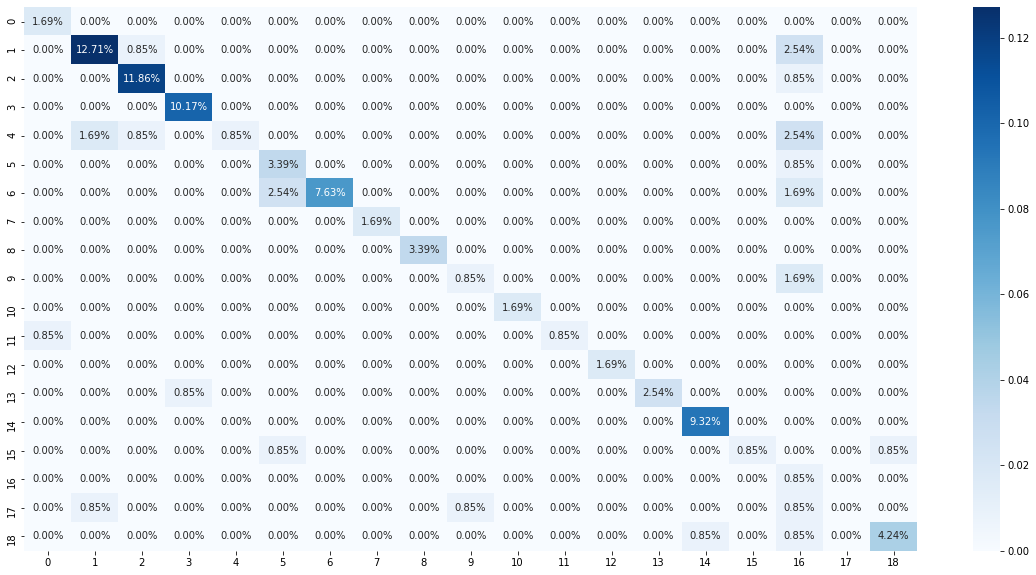

In [11]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize = (20,10))
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', annot_kws={"size": 10})

accuracy = accuracy_score(test_generator.classes, y_pred)
print("Accuracy in test set: %0.1f%% " % (accuracy * 100))

The confusion matrix above compares to what extent the model confused a class with the rest. The X axis is for the predicted classes while the Y axis contains the true labels. The scores of a class go horizontally, and it shows that several classes have not been classified correctly.

In [12]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print(metrics.classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.83      0.79      0.81        19
           2       0.88      0.93      0.90        15
           3       0.92      1.00      0.96        12
           4       1.00      0.14      0.25         7
           5       0.50      0.80      0.62         5
           6       1.00      0.64      0.78        14
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         4
           9       0.50      0.33      0.40         3
          10       1.00      1.00      1.00         2
          11       1.00      0.50      0.67         2
          12       1.00      1.00      1.00         2
          13       1.00      0.75      0.86         4
          14       0.92      1.00      0.96        11
          15       1.00      0.33      0.50         3
          16       0.07      1.00      0.12         1
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
'''
import numpy as np
import tensorflow as tf
from tensorflow import keras
from google.colab import files

files.download('plankton_classifier2.h5')
model.save('plankton_classifier2.h5')
'''

"\nimport numpy as np\nimport tensorflow as tf\nfrom tensorflow import keras\nfrom google.colab import files\n\nfiles.download('plankton_classifier2.h5')\nmodel.save('plankton_classifier2.h5')\n"

### B. Pretrained model in Finetune mode
Variant 1: Unfreeze last conv block of the pretrained model

In [14]:
model = models.load_model("plankton_classifier2.h5")
print([layer.name for layer in model.get_layer('vgg16').layers])

['input_1', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']


In [15]:
'''
blocks = ['block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']
for layer in model.get_layer('vgg16').layers:
    if layer == 'block5_conv1':
       layer.trainable = True
'''

for i, layer in enumerate(model.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)    

model.get_layer('vgg16').layers[15].trainable = True
model.get_layer('vgg16').layers[16].trainable = True
model.get_layer('vgg16').layers[17].trainable = True
model.get_layer('vgg16').layers[18].trainable = True

#try this
#model.get_layer('vgg16').layers['block5_conv1'].trainable = True

print(model.get_layer('vgg16').layers[15].name, " = ", model.get_layer('vgg16').layers[15].trainable) 
print(model.get_layer('vgg16').layers[18].name, " = ", model.get_layer('vgg16').layers[18].trainable)   


0 input_1 True
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False
block5_conv1  =  True
block5_pool  =  True


In [16]:
for i, layer in enumerate(model.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [17]:
#model = models.load_model("plankton_classifier.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 19)                4883      
Total params: 21,142,355
Trainable params: 13,507,091
Non-trainable params: 7,635,264
_________________________________________________________________


In [18]:
learning_rate = 1e-5
epochs = 100
checkpoint = ModelCheckpoint("plankton_classifier_ft.h5", 
                             monitor = 'val_acc',
                             verbose=1, 
                             save_best_only = True, 
                             save_Weights_only = False, 
                             mode = 'auto', period=1)

model.compile(loss = "categorical_crossentropy", 
              optimizer = optimizers.Adam(lr = learning_rate, clipnorm = 1.),
              metrics = ['acc'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=stepPerEpoch_training, 
                              epochs=epochs,
                              shuffle=True,
                              validation_data=val_generator,
                              callbacks=[checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
9/9 [==============================] - 27s 3s/step - loss: 0.9117 - acc: 0.7147 - val_loss: 0.8095 - val_acc: 0.7849

Epoch 00001: val_acc improved from -inf to 0.78495, saving model to plankton_classifier_ft.h5
Epoch 2/100
9/9 [==============================] - 23s 3s/step - loss: 0.7828 - acc: 0.8068 - val_loss: 0.7628 - val_acc: 0.7419

Epoch 00002: val_acc did not improve from 0.78495
Epoch 3/100
9/9 [==============================] - 25s 3s/step - loss: 0.8399 - acc: 0.7793 - val_loss: 0.7206 - val_acc: 0.7849

Epoch 00003: val_acc did not improve from 0.78495
Epoch 4/100
9/9 [==============================] - 24s 3s/step - loss: 0.9903 - acc: 0.6887 - val_loss: 0.6928 - val_acc: 0.7957

Epoch 00004: val_acc improved from 0.78495 to 0.79570, saving model to plankton_classifier_ft.h5
Epoch 5/100
9/9 [==============================] - 23s 2s/step - loss: 0.8527 - acc: 0.7339 - val_loss: 0.6504 - val_acc: 0.7742

Epoch 00005: val_acc did not improve from 0.79570
Epoch 6/1

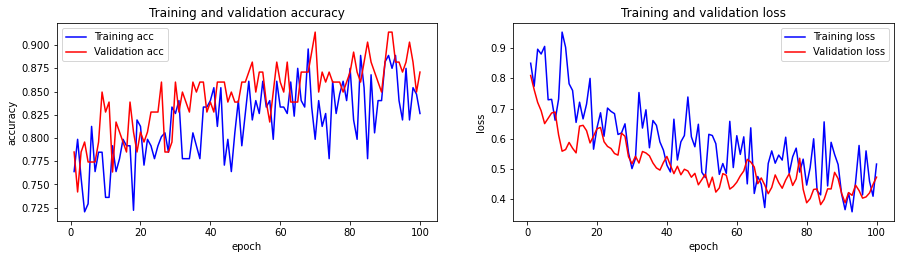

In [19]:
model = models.load_model("plankton_classifier_ft.h5")

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(epochs, acc, 'b', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
#plt.savefig('Accuracy.jpg')

plt.subplot(222)
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Accuracy in test set: 87.3% 


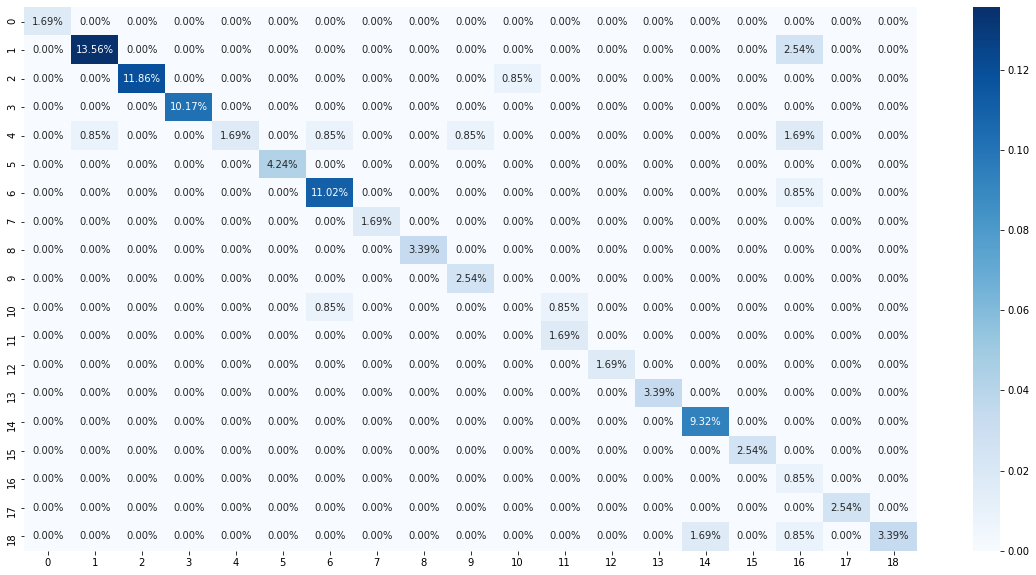

In [20]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize = (20,10))
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', annot_kws={"size": 10})   #plot with axis none too

accuracy = accuracy_score(test_generator.classes, y_pred)
print("Accuracy in test set: %0.1f%% " % (accuracy * 100))

The accuracy of the model improved. From the confusion matrix above, classes 4 and 10 are missclassified, but all the rest classes are classified correctly.

In [21]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print(metrics.classification_report(test_generator.classes, y_pred))
print("F1_Score: ", f1_score(test_generator.classes, y_pred, average="macro"))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.94      0.84      0.89        19
           2       1.00      0.93      0.97        15
           3       1.00      1.00      1.00        12
           4       1.00      0.29      0.44         7
           5       1.00      1.00      1.00         5
           6       0.87      0.93      0.90        14
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         4
           9       0.75      1.00      0.86         3
          10       0.00      0.00      0.00         2
          11       0.67      1.00      0.80         2
          12       1.00      1.00      1.00         2
          13       1.00      1.00      1.00         4
          14       0.85      1.00      0.92        11
          15       1.00      1.00      1.00         3
          16       0.12      1.00      0.22         1
          17       1.00    

Varient 2: Unfreezing another block4 conv layer and with batch_size = 1

In [40]:
model = models.load_model("plankton_classifier_ft.h5")

In [41]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 19)                4883      
Total params: 21,142,355
Trainable params: 13,507,091
Non-trainable params: 7,635,264
_________________________________________________________________


In [42]:

train_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,                                 
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   brightness_range = (0.9,1.1),
                                   fill_mode='nearest')
 
val_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(rescale = 1./255)

print('Total number of images for training: ')
train_generator = train_datagen.flow_from_directory(train_path, 
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size, 
                                                    class_mode = "categorical")

print('Total number of images for validation: ')
val_generator = val_datagen.flow_from_directory(validation_path,
                                                target_size=(img_height, img_width),
                                                batch_size=batch_size, 
                                                class_mode = "categorical",
                                                shuffle = False)
                                                
print('Total number of images for testing: ')
test_generator = test_datagen.flow_from_directory(test_path,
                                                target_size=(img_height, img_width),
                                                batch_size=batch_size, 
                                                class_mode = "categorical",
                                                shuffle = False)    

Total number of images for training: 
Found 2872 images belonging to 19 classes.
Total number of images for validation: 
Found 93 images belonging to 19 classes.
Total number of images for testing: 
Found 118 images belonging to 19 classes.


In [43]:
'''
conv_base.trainable = True

for layer in conv_base.layers[:15]:
  layer.trainable = False

for i, layer in enumerate(conv_base.layers):
    print(i, layer.name, layer.trainable)
''' 

for i, layer in enumerate(model.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)     

0 input_1 True
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [44]:
model.get_layer('vgg16').layers[11].trainable = True
model.get_layer('vgg16').layers[12].trainable = True
model.get_layer('vgg16').layers[13].trainable = True
model.get_layer('vgg16').layers[14].trainable = True 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 19)                4883      
Total params: 21,142,355
Trainable params: 19,406,867
Non-trainable params: 1,735,488
_________________________________________________________________


In [45]:
learning_rate = 1e-5
epochs = 100
stepPerEpoch_training =  150 // batch_size
checkpoint = ModelCheckpoint("plankton_classifier_ft2.h5", 
                             monitor = 'val_acc',
                             verbose=1, 
                             save_best_only = True, 
                             save_Weights_only = False, 
                             mode = 'auto', period=1)

model.compile(loss = "categorical_crossentropy", 
              optimizer = optimizers.Adam(lr = learning_rate, clipnorm = 1.),
              metrics = ['acc'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=stepPerEpoch_training, 
                              epochs=epochs,
                              shuffle=True,
                              validation_data=val_generator,
                              callbacks=[checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
9/9 [==============================] - 28s 3s/step - loss: 0.4902 - acc: 0.8431 - val_loss: 0.5571 - val_acc: 0.8065

Epoch 00001: val_acc improved from -inf to 0.80645, saving model to plankton_classifier_ft2.h5
Epoch 2/100
9/9 [==============================] - 21s 2s/step - loss: 0.6108 - acc: 0.8045 - val_loss: 0.4702 - val_acc: 0.8280

Epoch 00002: val_acc improved from 0.80645 to 0.82796, saving model to plankton_classifier_ft2.h5
Epoch 3/100
9/9 [==============================] - 26s 3s/step - loss: 0.5282 - acc: 0.8639 - val_loss: 0.4940 - val_acc: 0.8495

Epoch 00003: val_acc improved from 0.82796 to 0.84946, saving model to plankton_classifier_ft2.h5
Epoch 4/100
9/9 [==============================] - 24s 3s/step - loss: 0.6613 - acc: 0.7528 - val_loss: 0.5539 - val_acc: 0.8172

Epoch 00004: val_acc did not improve from 0.84946
Epoch 5/100
9/9 [==============================] - 28s 3s/step - loss: 0.4905 - acc: 0.8050 - val_loss: 0.5448 - val_acc: 0.8710

Epoch 000

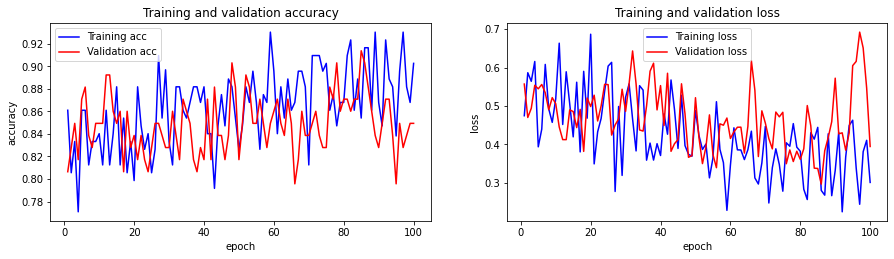

In [58]:
model = models.load_model("plankton_classifier_ft2.h5")

from scipy.interpolate import interp1d

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

#acc = interp1d(val_acc, acc)
#acc = gaussian_filter(acc, sigma=5)
#val_acc = gaussian_filter(val_acc, sigma=5)

plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(epochs, acc, 'b', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
#plt.savefig('Accuracy.jpg')

#loss = gaussian_filter(loss, sigma=5)
#val_loss = gaussian_filter(val_loss, sigma=5)

plt.subplot(222)
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()

plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Accuracy in test set: 88.1% 


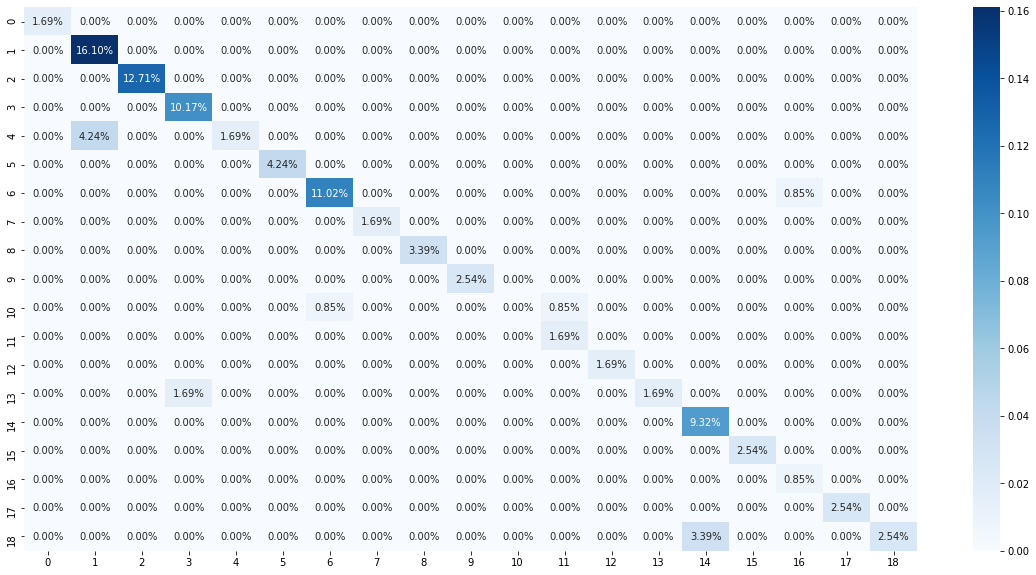

In [48]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize = (20,10))
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', annot_kws={"size": 10})   #plot with axis none too

accuracy = accuracy_score(test_generator.classes, y_pred)
print("Accuracy in test set: %0.1f%% " % (accuracy * 100))

In [49]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print(metrics.classification_report(test_generator.classes, y_pred))
print("F1_Score: ", f1_score(test_generator.classes, y_pred, average="macro"))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.79      1.00      0.88        19
           2       1.00      1.00      1.00        15
           3       0.86      1.00      0.92        12
           4       1.00      0.29      0.44         7
           5       1.00      1.00      1.00         5
           6       0.93      0.93      0.93        14
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         3
          10       0.00      0.00      0.00         2
          11       0.67      1.00      0.80         2
          12       1.00      1.00      1.00         2
          13       1.00      0.50      0.67         4
          14       0.73      1.00      0.85        11
          15       1.00      1.00      1.00         3
          16       0.50      1.00      0.67         1
          17       1.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Variant 4: retrain the first variant with more epochs  

In [ ]:
#model = models.load_model("plankton_classifier_ft.h5")

batch_size = 1
stepPerEpoch_training =  150 // batch_size
learning_rate = 1e-5
epochs = 50

checkpoint = ModelCheckpoint("plankton_classifier_ft3.h5", 
                             monitor = 'val_acc',
                             verbose=1, 
                             save_best_only = True, 
                             save_Weights_only = False, 
                             mode = 'auto', period=1)

model.compile(loss = "categorical_crossentropy", 
              optimizer = optimizers.Adam(lr = learning_rate, clipnorm = 1.),
              metrics = ['acc'])

history = model.fit_generator(train_generator,
                              steps_per_epoch=stepPerEpoch_training, 
                              epochs=epochs,
                              shuffle=True,
                              validation_data=val_generator,
                              callbacks=[checkpoint])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
150/150 [==============================] - 436s 3s/step - loss: 0.3658 - acc: 0.8822 - val_loss: 0.4670 - val_acc: 0.8817

Epoch 00001: val_acc improved from -inf to 0.88172, saving model to plankton_classifier_ft3.h5
Epoch 2/50
150/150 [==============================] - 438s 3s/step - loss: 0.3214 - acc: 0.8937 - val_loss: 0.5494 - val_acc: 0.8710

Epoch 00002: val_acc did not improve from 0.88172
Epoch 3/50
150/150 [==============================] - 446s 3s/step - loss: 0.3154 - acc: 0.8912 - val_loss: 0.6843 - val_acc: 0.8495

Epoch 00003: val_acc did not improve from 0.88172
Epoch 4/50
150/150 [==============================] - 448s 3s/step - loss: 0.3571 - acc: 0.8914 - val_loss: 0.5030 - val_acc: 0.8602

Epoch 00004: val_acc did not improve from 0.88172
Epoch 5/50
150/150 [==============================] - 445s 3s/step - loss: 0.3072 - acc: 0.8920 - val_loss: 0.7057 - val_acc: 0.8387

Epoch 00005: val_acc did not improve from 0.88172
Epoch 6/50
150/150 [===============

In [1]:
model = models.load_model("plankton_classifier_ft3.h5")

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(epochs, acc, 'b', label = 'Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
#plt.savefig('Accuracy.jpg')

plt.subplot(222)
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()

plt.show()

NameError: ignored

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Accuracy in test set: 82.2% 


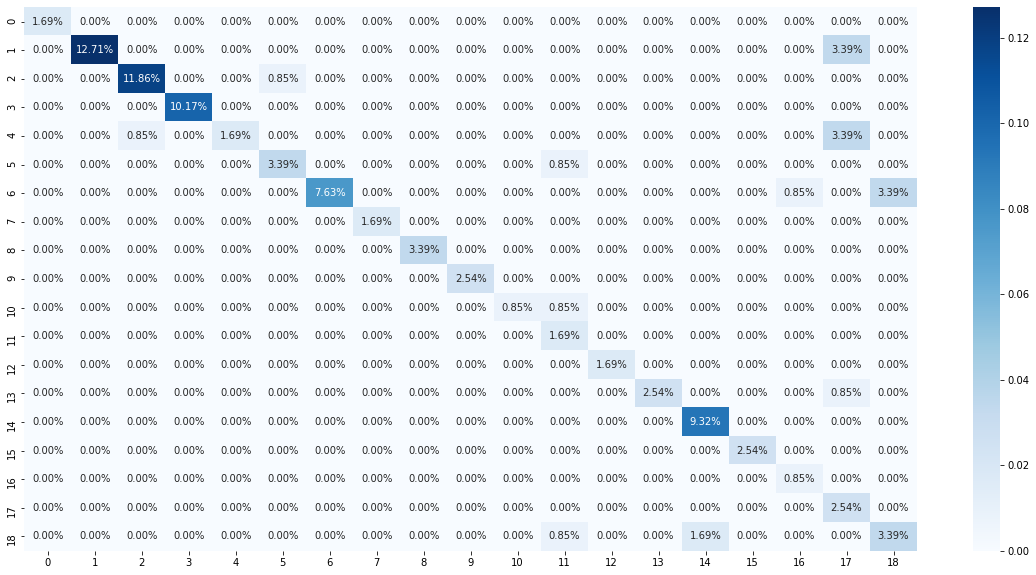

In [31]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize = (20,10))
sns.heatmap(cm/np.sum(cm), annot=True, fmt='.2%', cmap='Blues', annot_kws={"size": 10})   #plot with axis none too

accuracy = accuracy_score(test_generator.classes, y_pred)
print("Accuracy in test set: %0.1f%% " % (accuracy * 100))

In [32]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print(metrics.classification_report(test_generator.classes, y_pred))
print("F1_Score: ", f1_score(test_generator.classes, y_pred, average="macro"))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      0.79      0.88        19
           2       0.93      0.93      0.93        15
           3       1.00      1.00      1.00        12
           4       1.00      0.29      0.44         7
           5       0.80      0.80      0.80         5
           6       1.00      0.64      0.78        14
           7       1.00      1.00      1.00         2
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         3
          10       1.00      0.50      0.67         2
          11       0.40      1.00      0.57         2
          12       1.00      1.00      1.00         2
          13       1.00      0.75      0.86         4
          14       0.85      1.00      0.92        11
          15       1.00      1.00      1.00         3
          16       0.50      1.00      0.67         1
          17       0.25    

In [33]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing.image import load_img
import numpy as np

img = load_img("/content/drive/MyDrive/Deep learning Class Project/2_1.png", target_size=(224, 224))

x = image.img_to_array(img)             
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
print('Predicted class index:', preds) 

ValueError: ignored

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
model.save('plankton_classifier2.h5')
model.save('plankton_classifier_ft.h5')
model.save('plankton_classifier_ft2.h5')
model.save('plankton_classifier_ft3.h5')